Imports

In [1]:
%pip install tensorflow


import matplotlib.pyplot as plt
import numpy as np
import os
# import PIL
# from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
import seaborn as sn; sn.set(font_scale=1.4)
# from sklearn.utils import shuffle           
from skimage.io import imread
from keras.layers import Input, Dense
from tensorflow import keras
from keras import layers
# from keras.datasets import mnist
from keras.models import Sequential
from skimage import transform
from skimage.color import rgb2gray
from keras.utils.vis_utils import plot_model
# from keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# from sklearn.preprocessing import LabelEncoder
import os.path
from os import path

from google.colab import drive 

# import cv2                                 
# from tqdm import tqdm
# from collections import Counter
# from keras.preprocessing.image import ImageDataGenerator
# import pandas as pd


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
def clone_or_pull(repo_directory, repo_url):
  if path.exists(repo_directory):
      %cd $repo_directory
      !git reset --hard HEAD
      !git pull --force --no-rebase origin main
  else:
      !git clone $repo_url

drive.mount('/content/drive', force_remount=True)
%cd /content/drive/My Drive/

repo_dir='utn-ia-2023'
repo_url='https://github.com/RonanCamargo/utn-ia-2023'
clone_or_pull(repo_dir, repo_url)


Mounted at /content/drive
/content/drive/My Drive
/content/drive/My Drive/utn-ia-2023
Updating files: 100% (960/960), done.
HEAD is now at b0a8f60 Add more test images
From https://github.com/RonanCamargo/utn-ia-2023
 * branch            main       -> FETCH_HEAD
Already up to date.


Configuraciones

In [3]:
dataset_dir = "/content/drive/My Drive/utn-ia-2023/dataset"
training_images_folder="train"
test_images_folder="test"

training_dir = os.path.join(dataset_dir, training_images_folder)
testing_dir = os.path.join(dataset_dir, test_images_folder)

felines = ['Guepardo','Jaguar','Puma','Leopardo_de_nieve']
image_size = (32, 32)
model_input_shape = image_size + (1,)
output_layer_neurons = len(felines) # image type array length
hidden_layer_neurons = [512, 256, 128]
training_epochs = 1000
learning_rate = 0.0001
training_batch_size = 64

#https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
#https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/
hidden_layer_activation_function = 'relu'
output_layer_activation_function = 'softmax'

Funciones auxiliares

In [4]:

import os
import numpy as np
from skimage.io import imread

def load_data(directory):
    labels = []
    images = []
    label_index = 0

    for subdirectory in os.listdir(directory):
        if os.path.isdir(os.path.join(directory, subdirectory)):
            label_directory = os.path.join(directory, subdirectory)
            file_names = [os.path.join(label_directory, f) 
                          for f in os.listdir(label_directory) 
                          if f.lower().endswith((".jpg", ".jpeg"))]

            for file_name in file_names:
                image = imread(file_name)
                images.append(image)
                labels.append(label_index)

            label_index += 1

    return np.array(images), np.array(labels)

import numpy as np
from skimage.transform import resize

def resize_images(images, image_resize):
    processed_images = []

    for image in images:
        try:
            processed_image = resize(image, image_resize)
            processed_images.append(processed_image)
        except Exception as e:
            print(f"An error occurred while resizing an image: {str(e)}")

    return np.array(processed_images)

Cambiar tamaño y convertir a escala de grises

In [5]:
train_images, train_labels = load_data(training_dir)
train_images_resized = resize_images(train_images, image_size)
train_images_gray = rgb2gray(train_images_resized)

test_images, test_labels = load_data(testing_dir)
test_images_resized = resize_images(test_images, image_size)
test_images_gray = rgb2gray(test_images_resized)

Modelo (RNA)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 entrada (Flatten)           (None, 1024)              0         
                                                                 
 capa_oculta_1 (Dense)       (None, 512)               524800    
                                                                 
 capa_oculta_2 (Dense)       (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 capa_oculta_3 (Dense)       (None, 128)               32896     
                                                                 
 salida (Dense)              (None, 4)                 516       
                                                                 
Total params: 689,540
Trainable params: 689,540
Non-tr

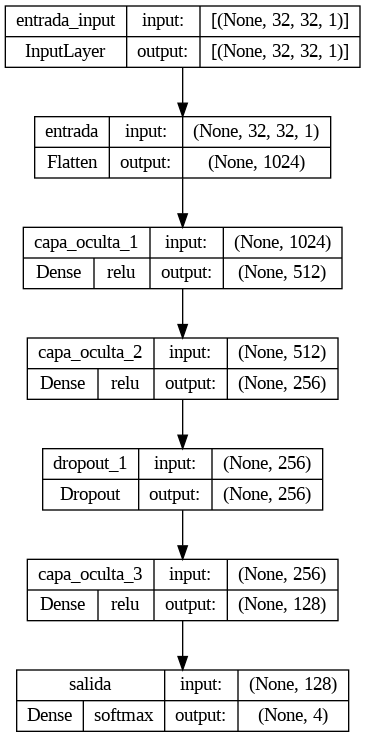

In [14]:
model= keras.Sequential([
    keras.layers.Flatten(input_shape = model_input_shape, name = "entrada"),
    keras.layers.Dense(hidden_layer_neurons[0], activation=hidden_layer_activation_function, name = "capa_oculta_1"),
    keras.layers.Dense(hidden_layer_neurons[1], activation=hidden_layer_activation_function, name = "capa_oculta_2"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(hidden_layer_neurons[2], activation=hidden_layer_activation_function, name = "capa_oculta_3"),
    keras.layers.Dense(output_layer_neurons, activation=output_layer_activation_function, name="salida")
])

model.compile(keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

model.summary()
plot_model(model, 
           show_layer_names = True, 
           show_shapes = True, 
           show_layer_activations = True)



Entrenar modelo

In [15]:
history = model.fit(np.array(train_images_gray), 
                    train_labels,
                    batch_size = training_batch_size,
                    epochs = training_epochs,
                    workers = 1,
                    use_multiprocessing = False)

Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


12/12 [==============================] - 1s 15ms/step - loss: 1.3961 - accuracy: 0.2527
Epoch 2/1000
12/12 [==============================] - 0s 14ms/step - loss: 1.3791 - accuracy: 0.2932
Epoch 3/1000
12/12 [==============================] - 0s 12ms/step - loss: 1.3593 - accuracy: 0.3203
Epoch 4/1000
12/12 [==============================] - 0s 12ms/step - loss: 1.3345 - accuracy: 0.3730
Epoch 5/1000
12/12 [==============================] - 0s 13ms/step - loss: 1.3245 - accuracy: 0.3932
Epoch 6/1000
12/12 [==============================] - 0s 14ms/step - loss: 1.3178 - accuracy: 0.3486
Epoch 7/1000
12/12 [==============================] - 0s 13ms/step - loss: 1.3041 - accuracy: 0.3824
Epoch 8/1000
12/12 [==============================] - 0s 14ms/step - loss: 1.2786 - accuracy: 0.4338
Epoch 9/1000
12/12 [==============================] - 0s 12ms/step - loss: 1.2758 - accuracy: 0.4459
Epoch 10/1000
12/12 [==============================] - 0s 14ms/step - loss: 1.2608 - accuracy: 0.4554
Ep

Información sobre el entrenamiento

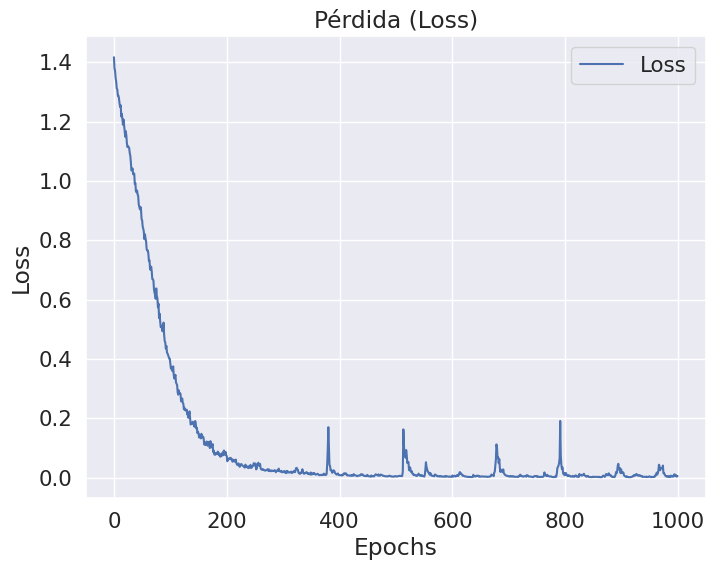

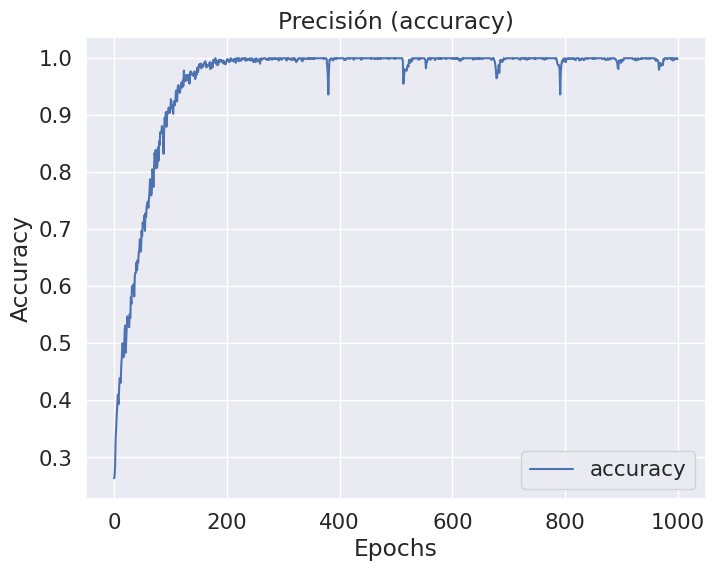

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Extract loss and accuracy values from the history object
loss = history.history['loss']
accuracy = history.history['accuracy']

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Loss')
plt.title('Pérdida (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(accuracy, label='accuracy')
plt.title('Precisión (accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Clasificar imágenes


In [9]:
print_summary = 2
test_loss, test_acc = model.evaluate(test_images_gray, test_labels, verbose=print_summary)

print("Resultado de clasificación: ")
print('\tExactitud de prueba:', test_acc)
print('\tPérdida:', test_loss)

predictions = model.predict(test_images_gray)

7/7 - 0s - loss: 3.9968 - accuracy: 0.3495 - 187ms/epoch - 27ms/step
Resultado de clasificación: 
	Exactitud de prueba: 0.34951457381248474
	Pérdida: 3.9968433380126953
7/7 [==============================] - 0s 3ms/step


Matriz de confusión

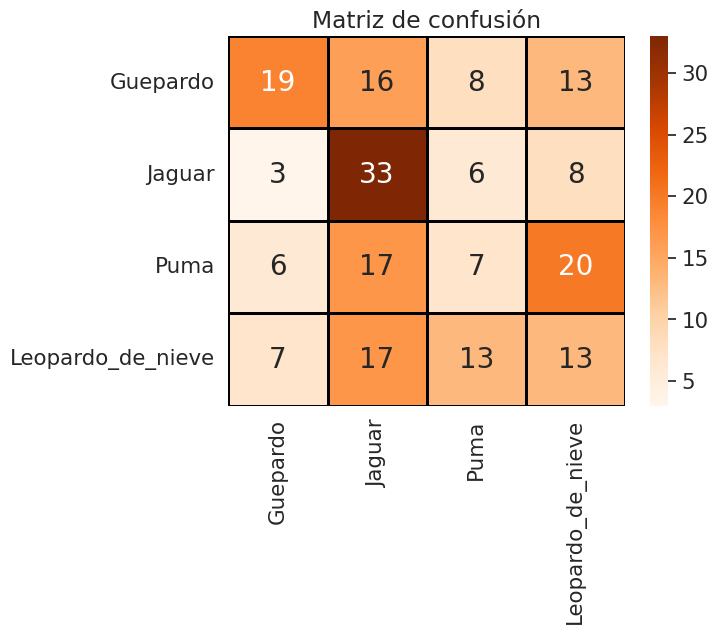

In [10]:
#https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/#:~:text=Plot%20Confusion%20Matrix%20for%20Binary%20Classes%20With%20Labels&text=You%20need%20to%20create%20a,matrix%20with%20the%20labels%20annotation.
axes = plt.axes()
axes.set_title('Matriz de confusión')
axes.set_ylabel('Original')
axes.set_xlabel('Clasificación')

#https://matplotlib.org/stable/tutorials/colors/colormaps.html
colormap='Oranges'

pred_labels = np.argmax(predictions, axis = 1)
matrix = confusion_matrix(test_labels, pred_labels)

sn.heatmap(matrix, annot=True, annot_kws={"size": 20}, xticklabels=felines, yticklabels=felines, ax=axes, cmap=colormap, cbar=True,linecolor='black',linewidths=2)
plt.show()

In [11]:
predictions = model.predict(test_images_gray)
y_pred = np.argmax(predictions, axis=1)

print('Reporte de clasificación')
print(classification_report(test_labels, y_pred, target_names=felines, zero_division=0))

7/7 [==============================] - 0s 4ms/step
Reporte de clasificación
                   precision    recall  f1-score   support

         Guepardo       0.54      0.34      0.42        56
           Jaguar       0.40      0.66      0.50        50
             Puma       0.21      0.14      0.17        50
Leopardo_de_nieve       0.24      0.26      0.25        50

         accuracy                           0.35       206
        macro avg       0.35      0.35      0.33       206
     weighted avg       0.35      0.35      0.34       206



Funciones clasificación

In [12]:
def label_color(predicted, original):
  if predicted == original:
    return 'green'
  else:
    return 'red'

def plot_image(i, predictions_array, right_label, img):
  predictions_array, right_label, img = predictions_array, right_label[i], img[i]
  predicted_label = np.argmax(predictions_array)
  color = label_color(predicted_label, right_label)

  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap=plt.cm.binary)
  plt.title("{}".format(felines[right_label]))
  plt.xlabel("Clasificación: {}".format(felines[predicted_label]), color=color)
    
# def plot(predictions, test_labels, test_images):
#   for i in range(len(predictions)):
#     plt.figure(figsize=(12,30))
#     plt.subplot(1,2,1)
#     plot_image(i, predictions[i], test_labels, test_images)
#     plt.show()

def plot(predictions, test_labels, test_images):
    unique_labels = np.unique(test_labels)
    for label in unique_labels[:3]:  # Plot only the first 3 unique labels
        indices = np.where(test_labels == label)[0][:3]  # Get the indices of the label
        for i in indices:
            plt.figure(figsize=(12, 30))
            plt.subplot(1, 2, 1)
            plot_image(i, predictions[i], test_labels, test_images)
            plt.show()


Mostrar clasificación

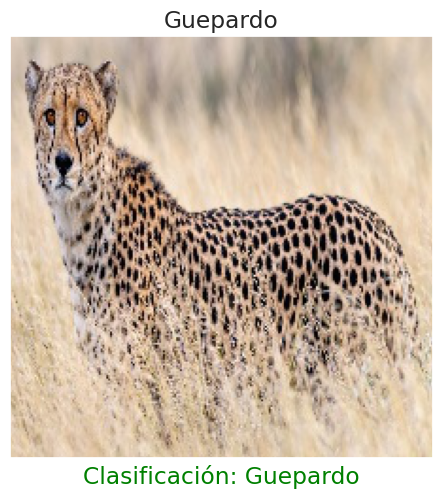

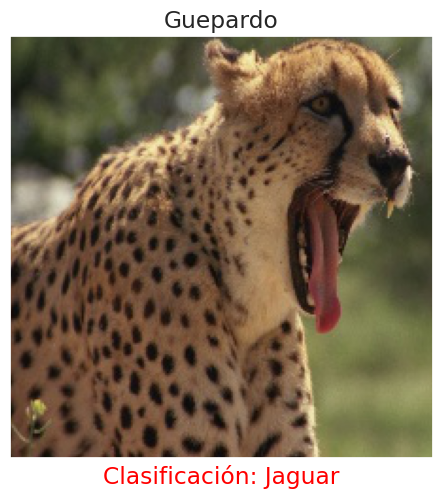

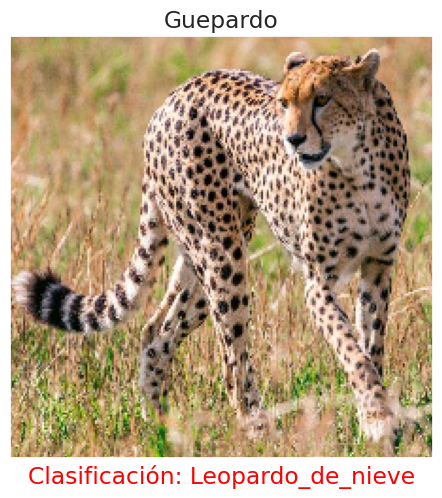

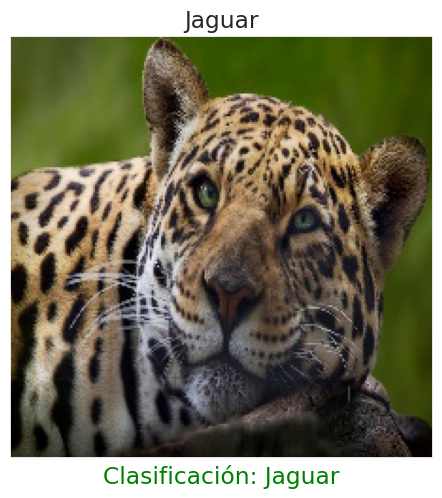

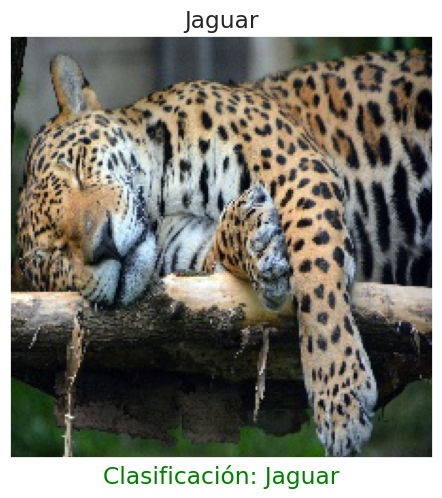

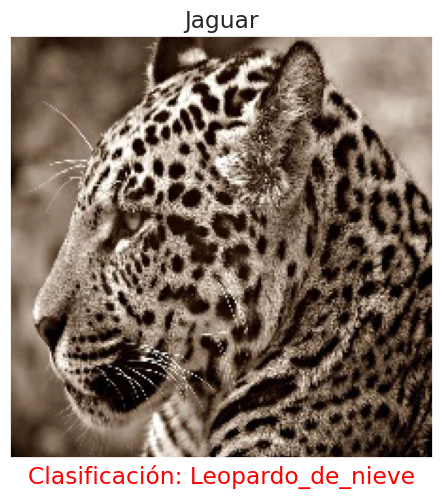

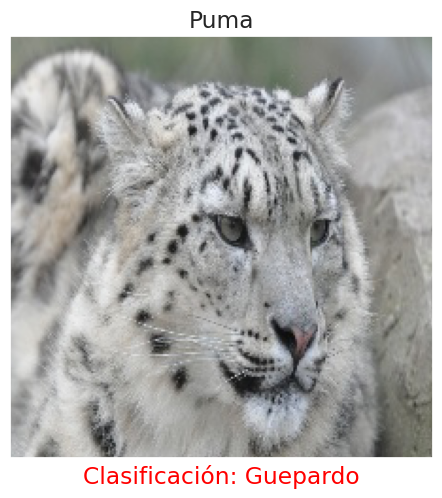

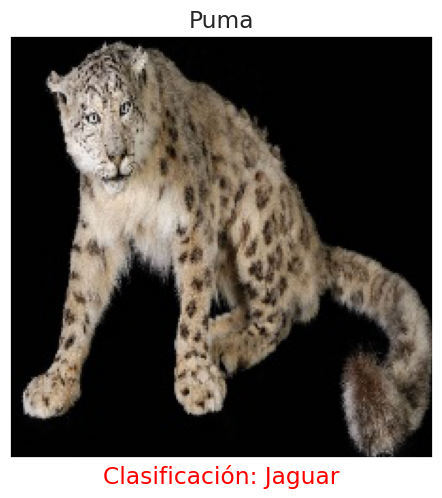

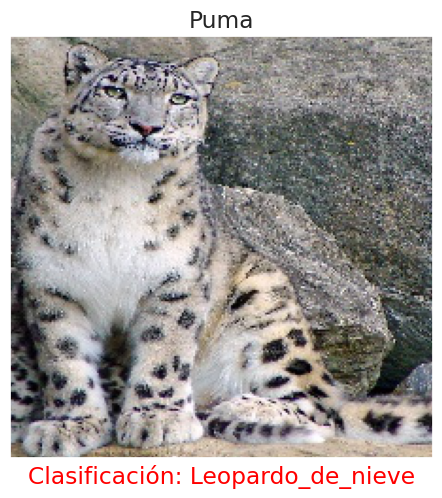

In [13]:
plot(predictions, test_labels, test_images)